In [69]:
import os

DATASET_PATH = "C:\\Users\\Nilesh\\multispectral_image_dehazing\\Data_for_dehazing model\\paired_data"
print("Dataset exists:", os.path.exists(DATASET_PATH))
print("Folders inside:", os.listdir(DATASET_PATH) if os.path.exists(DATASET_PATH) else "Path does not exist")


Dataset exists: True
Folders inside: ['test', 'train', 'validation']


In [71]:
import os

DATASET_PATH = "C:\\Users\\Nilesh\\multispectral_image_dehazing\\Data_for_dehazing model\\paired_data\\validation"
print("Dataset exists:", os.path.exists(DATASET_PATH))
print("Folders inside:", os.listdir(DATASET_PATH) if os.path.exists(DATASET_PATH) else "Path does not exist")


Dataset exists: True
Folders inside: ['input', 'target']


In [73]:
validation_output_path = os.path.join(DATASET_PATH, "validation", "Output")
print("Validation Output folder exists:", os.path.exists(validation_output_path))
print("Files inside:", os.listdir(validation_output_path) if os.path.exists(validation_output_path) else "Folder does not exist")


Validation Output folder exists: False
Files inside: Folder does not exist


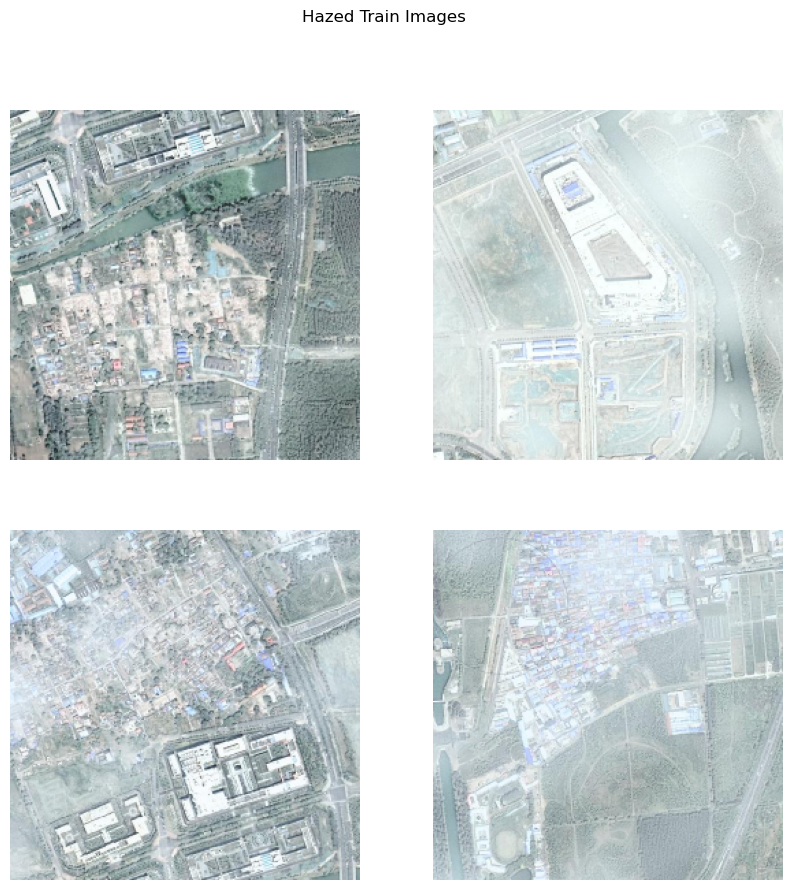

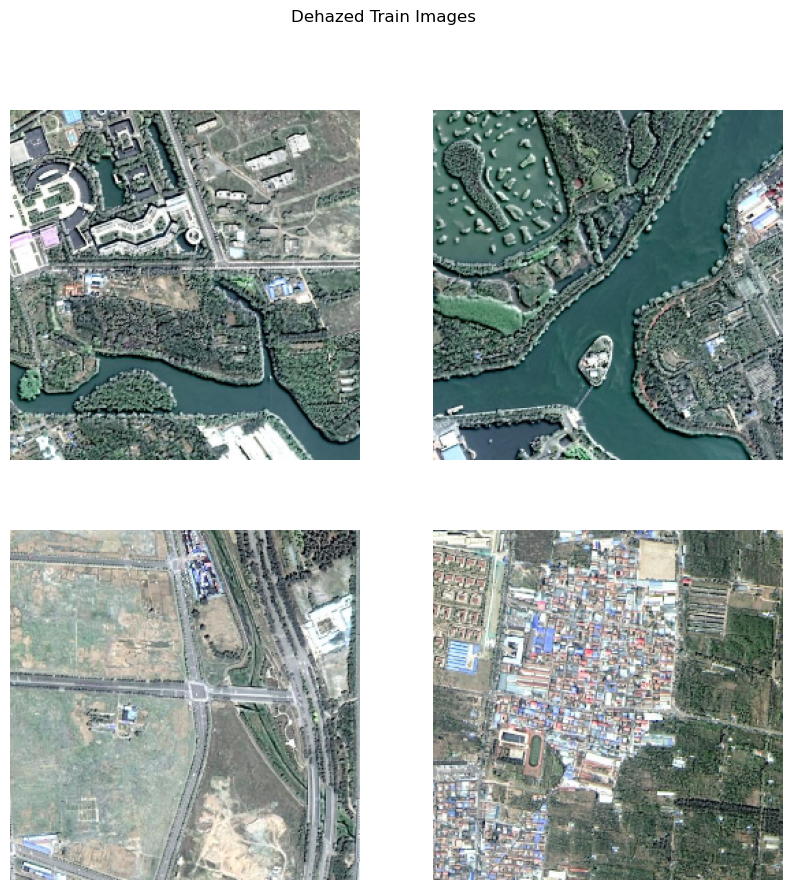

In [75]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt

def check_directory_exists(directory):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory not found: {directory}")
    elif not os.listdir(directory):
        raise FileNotFoundError(f"No files found in directory: {directory}")

# Define dataset paths
DATASET_PATH = "C:\\Users\\Nilesh\\multispectral_image_dehazing\\Data_for_dehazing model\\paired_data"

IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 16

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    return image

# Function to create a TensorFlow dataset
def create_dataset(directory):
    try:
        check_directory_exists(directory)
    except FileNotFoundError as e:
        print(e)
        return None
    
    image_paths = tf.data.Dataset.list_files(os.path.join(directory, "*"), shuffle=True)
    dataset = image_paths.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

# Dataset paths
Hazed_train_path = os.path.join(DATASET_PATH, "train", "Input")
Dehazed_train_path = os.path.join(DATASET_PATH, "train", "Output")
Hazed_val_path = os.path.join(DATASET_PATH, "validation", "input")
Dehazed_val_path = os.path.join(DATASET_PATH, "validation", "target")
Hazed_test_path = os.path.join(DATASET_PATH, "test", "Input")
Dehazed_test_path = os.path.join(DATASET_PATH, "test", "Output")

# Create datasets
Hazed_train_ds = create_dataset(Hazed_train_path)
Dehazed_train_ds = create_dataset(Dehazed_train_path)
Hazed_val_ds = create_dataset(Hazed_val_path)
Dehazed_val_ds = create_dataset(Dehazed_val_path)
Hazed_test_ds = create_dataset(Hazed_test_path)
Dehazed_test_ds = create_dataset(Dehazed_test_path)

# Display sample images
def display_sample(dataset, title):
    if dataset is not None:
        for image_batch in dataset.take(1):
            plt.figure(figsize=(10, 10))
            for i in range(min(4, image_batch.shape[0])):
                plt.subplot(2, 2, i + 1)
                plt.imshow(image_batch[i].numpy())
                plt.axis("off")
            plt.suptitle(title)
            plt.show()
    else:
        print(f"{title} dataset is missing or empty.")

# Visualize samples
display_sample(Hazed_train_ds, "Hazed Train Images")
display_sample(Dehazed_train_ds, "Dehazed Train Images")


In [77]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Data Loading & Preprocessing
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (256, 256))
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Generator Model (U-Net based)
def build_generator():
    inputs = Input(shape=(256, 256, 3))
    
    down1 = Conv2D(64, (4,4), strides=2, padding='same', activation='relu')(inputs)
    down2 = Conv2D(128, (4,4), strides=2, padding='same', activation='relu')(down1)
    down3 = Conv2D(256, (4,4), strides=2, padding='same', activation='relu')(down2)
    
    up1 = Conv2DTranspose(128, (4,4), strides=2, padding='same', activation='relu')(down3)
    up2 = Conv2DTranspose(64, (4,4), strides=2, padding='same', activation='relu')(up1)
    
    outputs = Conv2DTranspose(3, (4,4), strides=2, padding='same', activation='tanh')(up2)
    
    return Model(inputs, outputs)

# Discriminator Model
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    target = Input(shape=(256, 256, 3))
    combined = Concatenate()([inputs, target])
    
    disc = Conv2D(64, (4,4), strides=2, padding='same', activation='relu')(combined)
    disc = Conv2D(128, (4,4), strides=2, padding='same', activation='relu')(disc)
    disc = Flatten()(disc)
    disc = Dense(1, activation='sigmoid')(disc)
    
    return Model([inputs, target], disc)

# Loss Functions
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Training Visualization
def visualize_predictions(generator, sample_input):
    prediction = generator(sample_input, training=False)
    plt.figure(figsize=(6,6))
    plt.imshow((prediction[0] + 1) / 2)
    plt.axis('off')
    plt.show()

# Initialize Models
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,507 (5.03 MB)

 Trainable params: 1,317,507 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (Concatenate)       │ 6)                │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 128, 128,  │      6,208 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    131,200 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 524288)    │          0 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │    524,289 │ flatten_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 661,697 (2.52 MB)

 Trainable params: 661,697 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================
# 1. Data Loading & Preprocessing
# ==========================
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (256, 256))
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# ==========================
# 2. Generator Model (U-Net based)
# ==========================
def build_generator():
    inputs = Input(shape=(256, 256, 3))
    
    down1 = Conv2D(64, (4,4), strides=2, padding='same', activation='relu')(inputs)
    down2 = Conv2D(128, (4,4), strides=2, padding='same', activation='relu')(down1)
    down3 = Conv2D(256, (4,4), strides=2, padding='same', activation='relu')(down2)
    
    up1 = Conv2DTranspose(128, (4,4), strides=2, padding='same', activation='relu')(down3)
    up2 = Conv2DTranspose(64, (4,4), strides=2, padding='same', activation='relu')(up1)
    
    outputs = Conv2DTranspose(3, (4,4), strides=2, padding='same', activation='tanh')(up2)
    
    return Model(inputs, outputs, name="Generator")

# ==========================
# 3. Discriminator Model
# ==========================
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    target = Input(shape=(256, 256, 3))
    combined = Concatenate()([inputs, target])
    
    disc = Conv2D(64, (4,4), strides=2, padding='same', activation='relu')(combined)
    disc = Conv2D(128, (4,4), strides=2, padding='same', activation='relu')(disc)
    disc = Flatten()(disc)
    disc = Dense(1, activation='sigmoid')(disc)
    
    return Model([inputs, target], disc, name="Discriminator")

# ==========================
# 4. Loss Functions
# ==========================
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (100 * l1_loss)  # Weighted L1 loss
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

# ==========================
# 5. Optimizers
# ==========================
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# ==========================
# 6. Initialize Models
# ==========================
generator_G = build_generator()
discriminator_X = build_discriminator()

generator_G.summary()
discriminator_X.summary()

# ==========================
# 7. Checkpoint Setup
# ==========================
CHECKPOINT_DIR = "./pix2pix_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

checkpoint = tf.train.Checkpoint(
    generator=generator_G,
    discriminator=discriminator_X,
    generator_optimizer=generator_G_optimizer,
    discriminator_optimizer=discriminator_X_optimizer,
    epoch=tf.Variable(0)  # Track the current epoch
)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

# Restore checkpoint if available
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print("Restored from checkpoint:", manager.latest_checkpoint)
    start_epoch = checkpoint.epoch.numpy()
else:
    start_epoch = 0

# ==========================
# 8. Training Step
# ==========================
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape(persistent=True) as tape:
        generated_image = generator_G(input_image, training=True)

        disc_real_output = discriminator_X([input_image, target_image], training=True)
        disc_generated_output = discriminator_X([input_image, generated_image], training=True)

        gen_loss = generator_loss(disc_generated_output, generated_image, target_image)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute gradients
    gen_gradients = tape.gradient(gen_loss, generator_G.trainable_variables)
    disc_gradients = tape.gradient(disc_loss, discriminator_X.trainable_variables)

    # Apply gradients
    generator_G_optimizer.apply_gradients(zip(gen_gradients, generator_G.trainable_variables))
    discriminator_X_optimizer.apply_gradients(zip(disc_gradients, discriminator_X.trainable_variables))

    return {"gen_loss": gen_loss, "disc_loss": disc_loss}

# ==========================
# 9. Training Loop
# ==========================
EPOCHS = 100

# Dummy dataset placeholder (Replace with actual dataset loading)
# Example: Assuming you have a dataset of hazy and dehazed image pairs
Hazed_train_ds = tf.data.Dataset.from_tensor_slices(np.random.randn(100, 256, 256, 3).astype(np.float32))
Dehazed_train_ds = tf.data.Dataset.from_tensor_slices(np.random.randn(100, 256, 256, 3).astype(np.float32))
train_dataset = tf.data.Dataset.zip((Hazed_train_ds, Dehazed_train_ds)).batch(1)

# Training loop with progress bars
for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epochs", unit="epoch"):
    epoch_losses = {"gen_loss": 0.0, "disc_loss": 0.0}
    num_batches = 0

    for hazy_img, dehazy_img in tqdm(train_dataset, desc="Batches", leave=False):
        losses = train_step(hazy_img, dehazy_img)

        # Accumulate losses
        for key in epoch_losses:
            epoch_losses[key] += losses[key]
        num_batches += 1

    # Compute average losses for the epoch
    avg_losses = {key: float(val) / num_batches for key, val in epoch_losses.items()}
    tqdm.write(f"Epoch {epoch+1}/{EPOCHS} Losses: {avg_losses}")
    
    # Save checkpoint after each epoch
    checkpoint.epoch.assign(epoch + 1)
    manager.save()
    print(f"Checkpoint saved at epoch {epoch+1}")

# ==========================
# 10. Save the trained generator model
# ==========================
generator_G.save("Nilesh_pix2pix_dehaze.keras")
print("Model saved successfully.")

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,507 (5.03 MB)

 Trainable params: 1,317,507 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 6)                │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      6,208 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    131,200 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 524288)    │          0 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │    524,289 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 661,697 (2.52 MB)

 Trainable params: 661,697 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

Restored from checkpoint: ./pix2pix_checkpoints\ckpt-4


Batches:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\Nilesh\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(

Epochs:   1%|          | 1/96 [00:16<25:39, 16.21s/epoch] 

Epoch 5/100 Losses: {'gen_loss': 93.74650390625, 'disc_loss': 0.4993852996826172}
Checkpoint saved at epoch 5



Epochs:   2%|▏         | 2/96 [00:27<21:17, 13.59s/epoch] 

Epoch 6/100 Losses: {'gen_loss': 93.9308984375, 'disc_loss': 0.3225361633300781}
Checkpoint saved at epoch 6



Epochs:   3%|▎         | 3/96 [00:39<19:41, 12.70s/epoch] 

Epoch 7/100 Losses: {'gen_loss': 99.672373046875, 'disc_loss': 0.5508183288574219}
Checkpoint saved at epoch 7



Epochs:   3%|▎         | 3/96 [04:32<19:41, 12.70s/epoch] 

Epoch 8/100 Losses: {'gen_loss': 101.3037890625, 'disc_loss': 0.5906153488159179}


Epochs:   4%|▍         | 4/96 [04:33<2:33:08, 99.87s/epoch]

Checkpoint saved at epoch 8



Epochs:   5%|▌         | 5/96 [04:44<1:42:56, 67.87s/epoch][A

Epoch 9/100 Losses: {'gen_loss': 102.8128515625, 'disc_loss': 0.5100185775756836}
Checkpoint saved at epoch 9



Epochs:   6%|▋         | 6/96 [04:53<1:12:04, 48.05s/epoch]A

Epoch 10/100 Losses: {'gen_loss': 103.190185546875, 'disc_loss': 0.5323822402954101}
Checkpoint saved at epoch 10



Epochs:   7%|▋         | 7/96 [05:02<52:14, 35.22s/epoch]  A

Epoch 11/100 Losses: {'gen_loss': 104.511015625, 'disc_loss': 0.35922008514404297}
Checkpoint saved at epoch 11



Epochs:   8%|▊         | 8/96 [05:12<39:42, 27.07s/epoch]

Epoch 12/100 Losses: {'gen_loss': 106.177646484375, 'disc_loss': 0.4544758605957031}
Checkpoint saved at epoch 12



Epochs:   9%|▉         | 9/96 [05:21<31:02, 21.41s/epoch] 

Epoch 13/100 Losses: {'gen_loss': 106.808115234375, 'disc_loss': 0.3888519287109375}
Checkpoint saved at epoch 13



Epochs:  10%|█         | 10/96 [05:30<25:30, 17.79s/epoch][A

Epoch 14/100 Losses: {'gen_loss': 108.545576171875, 'disc_loss': 0.2606548881530762}
Checkpoint saved at epoch 14



Epochs:  11%|█▏        | 11/96 [05:40<21:48, 15.40s/epoch][A

Epoch 15/100 Losses: {'gen_loss': 108.98095703125, 'disc_loss': 0.2748775863647461}
Checkpoint saved at epoch 15



Epochs:  12%|█▎        | 12/96 [05:50<18:55, 13.52s/epoch]

Epoch 16/100 Losses: {'gen_loss': 108.05232421875, 'disc_loss': 0.20681228637695312}
Checkpoint saved at epoch 16



Epochs:  14%|█▎        | 13/96 [05:59<16:50, 12.18s/epoch]

Epoch 17/100 Losses: {'gen_loss': 106.18529296875, 'disc_loss': 0.11193534851074219}
Checkpoint saved at epoch 17



Epochs:  15%|█▍        | 14/96 [06:08<15:27, 11.32s/epoch]

Epoch 18/100 Losses: {'gen_loss': 108.658056640625, 'disc_loss': 0.22167163848876953}
Checkpoint saved at epoch 18



Epochs:  16%|█▌        | 15/96 [06:17<14:28, 10.72s/epoch]

Epoch 19/100 Losses: {'gen_loss': 106.594833984375, 'disc_loss': 0.17705188751220702}
Checkpoint saved at epoch 19



Epochs:  17%|█▋        | 16/96 [06:27<13:43, 10.30s/epoch][A

Epoch 20/100 Losses: {'gen_loss': 107.12423828125, 'disc_loss': 0.12371688842773437}
Checkpoint saved at epoch 20



Epochs:  18%|█▊        | 17/96 [06:37<13:46, 10.46s/epoch][A

Epoch 21/100 Losses: {'gen_loss': 107.560498046875, 'disc_loss': 0.0965792179107666}
Checkpoint saved at epoch 21



Epochs:  19%|█▉        | 18/96 [06:47<13:15, 10.20s/epoch][A

Epoch 22/100 Losses: {'gen_loss': 107.155224609375, 'disc_loss': 0.09495553970336915}
Checkpoint saved at epoch 22



Epochs:  20%|█▉        | 19/96 [06:56<12:46,  9.96s/epoch]

Epoch 23/100 Losses: {'gen_loss': 108.26798828125, 'disc_loss': 0.1087800121307373}
Checkpoint saved at epoch 23



Epochs:  21%|██        | 20/96 [07:06<12:22,  9.77s/epoch]

Epoch 24/100 Losses: {'gen_loss': 108.028134765625, 'disc_loss': 0.08222652435302734}
Checkpoint saved at epoch 24



Epochs:  22%|██▏       | 21/96 [07:15<12:02,  9.64s/epoch][A

Epoch 25/100 Losses: {'gen_loss': 106.79693359375, 'disc_loss': 0.10222547531127929}
Checkpoint saved at epoch 25



Epochs:  23%|██▎       | 22/96 [07:24<11:43,  9.51s/epoch]

Epoch 26/100 Losses: {'gen_loss': 105.5730078125, 'disc_loss': 0.06827769279479981}
Checkpoint saved at epoch 26



Epochs:  24%|██▍       | 23/96 [07:34<11:39,  9.59s/epoch]

Epoch 27/100 Losses: {'gen_loss': 108.041416015625, 'disc_loss': 0.04888345718383789}
Checkpoint saved at epoch 27



Epochs:  25%|██▌       | 24/96 [07:44<11:32,  9.62s/epoch][A

Epoch 28/100 Losses: {'gen_loss': 107.033994140625, 'disc_loss': 0.11216320037841797}
Checkpoint saved at epoch 28



Epochs:  26%|██▌       | 25/96 [07:53<11:22,  9.61s/epoch]

Epoch 29/100 Losses: {'gen_loss': 105.58751953125, 'disc_loss': 0.07924248695373536}
Checkpoint saved at epoch 29



Epochs:  27%|██▋       | 26/96 [08:03<11:05,  9.51s/epoch][A

Epoch 30/100 Losses: {'gen_loss': 108.5193359375, 'disc_loss': 0.03235470533370972}
Checkpoint saved at epoch 30



Epochs:  28%|██▊       | 27/96 [08:12<10:55,  9.50s/epoch][A

Epoch 31/100 Losses: {'gen_loss': 108.7042578125, 'disc_loss': 0.07904044151306153}
Checkpoint saved at epoch 31



Epochs:  29%|██▉       | 28/96 [08:23<11:05,  9.78s/epoch]

Epoch 32/100 Losses: {'gen_loss': 107.337685546875, 'disc_loss': 0.06024378776550293}
Checkpoint saved at epoch 32



Epochs:  30%|███       | 29/96 [08:33<11:02,  9.89s/epoch]

Epoch 33/100 Losses: {'gen_loss': 107.788115234375, 'disc_loss': 0.020244805812835692}
Checkpoint saved at epoch 33



Epochs:  31%|███▏      | 30/96 [08:43<10:58,  9.98s/epoch]

Epoch 34/100 Losses: {'gen_loss': 108.599052734375, 'disc_loss': 0.025575318336486817}
Checkpoint saved at epoch 34



Epochs:  32%|███▏      | 31/96 [08:53<10:51, 10.03s/epoch]

Epoch 35/100 Losses: {'gen_loss': 109.680810546875, 'disc_loss': 0.045123052597045896}
Checkpoint saved at epoch 35



Epochs:  33%|███▎      | 32/96 [09:03<10:41, 10.02s/epoch][A

Epoch 36/100 Losses: {'gen_loss': 104.9262890625, 'disc_loss': 0.08916975021362304}
Checkpoint saved at epoch 36



Epochs:  34%|███▍      | 33/96 [09:13<10:28,  9.98s/epoch]

Epoch 37/100 Losses: {'gen_loss': 103.457880859375, 'disc_loss': 0.050800113677978515}
Checkpoint saved at epoch 37



Epochs:  35%|███▌      | 34/96 [09:24<10:31, 10.18s/epoch]

Epoch 38/100 Losses: {'gen_loss': 105.201669921875, 'disc_loss': 0.035969300270080565}
Checkpoint saved at epoch 38



Epochs:  36%|███▋      | 35/96 [09:34<10:22, 10.21s/epoch][A

Epoch 39/100 Losses: {'gen_loss': 104.725751953125, 'disc_loss': 0.04574437141418457}
Checkpoint saved at epoch 39



Epochs:  38%|███▊      | 36/96 [09:44<10:12, 10.21s/epoch]

Epoch 40/100 Losses: {'gen_loss': 104.647744140625, 'disc_loss': 0.06387866497039794}
Checkpoint saved at epoch 40



Epochs:  39%|███▊      | 37/96 [09:54<09:56, 10.11s/epoch][A

Epoch 41/100 Losses: {'gen_loss': 102.5677734375, 'disc_loss': 0.09504850387573242}
Checkpoint saved at epoch 41



Epochs:  40%|███▉      | 38/96 [10:05<09:55, 10.26s/epoch][A

Epoch 42/100 Losses: {'gen_loss': 103.971943359375, 'disc_loss': 0.09169398307800293}
Checkpoint saved at epoch 42



Epochs:  41%|████      | 39/96 [10:16<09:59, 10.52s/epoch]

Epoch 43/100 Losses: {'gen_loss': 105.180673828125, 'disc_loss': 0.01883810877799988}
Checkpoint saved at epoch 43



Epochs:  42%|████▏     | 40/96 [10:27<10:02, 10.75s/epoch]

Epoch 44/100 Losses: {'gen_loss': 109.662001953125, 'disc_loss': 0.017307032346725464}
Checkpoint saved at epoch 44



Epochs:  43%|████▎     | 41/96 [10:39<10:04, 11.00s/epoch]

Epoch 45/100 Losses: {'gen_loss': 106.281455078125, 'disc_loss': 0.08330181121826172}
Checkpoint saved at epoch 45



Epochs:  44%|████▍     | 42/96 [10:50<10:06, 11.24s/epoch]

Epoch 46/100 Losses: {'gen_loss': 103.663564453125, 'disc_loss': 0.11263535499572754}
Checkpoint saved at epoch 46



Epochs:  45%|████▍     | 43/96 [11:01<09:41, 10.97s/epoch]

Epoch 47/100 Losses: {'gen_loss': 109.5355078125, 'disc_loss': 0.12338995933532715}
Checkpoint saved at epoch 47



Epochs:  46%|████▌     | 44/96 [11:11<09:17, 10.73s/epoch][A

Epoch 48/100 Losses: {'gen_loss': 106.316767578125, 'disc_loss': 0.15514973640441895}
Checkpoint saved at epoch 48



Epochs:  47%|████▋     | 45/96 [11:21<09:02, 10.63s/epoch][A

Epoch 49/100 Losses: {'gen_loss': 107.130751953125, 'disc_loss': 0.09760797500610352}
Checkpoint saved at epoch 49



Epochs:  48%|████▊     | 46/96 [11:32<08:45, 10.51s/epoch]

Epoch 50/100 Losses: {'gen_loss': 105.81640625, 'disc_loss': 0.15975603103637695}
Checkpoint saved at epoch 50



Epochs:  49%|████▉     | 47/96 [11:42<08:31, 10.44s/epoch][A

Epoch 51/100 Losses: {'gen_loss': 103.2040234375, 'disc_loss': 0.13367527961730957}
Checkpoint saved at epoch 51



Epochs:  50%|█████     | 48/96 [11:52<08:21, 10.45s/epoch]

Epoch 52/100 Losses: {'gen_loss': 106.192998046875, 'disc_loss': 0.04672574996948242}
Checkpoint saved at epoch 52



Epochs:  51%|█████     | 49/96 [12:02<08:06, 10.35s/epoch]

Epoch 53/100 Losses: {'gen_loss': 108.838603515625, 'disc_loss': 0.0876073932647705}
Checkpoint saved at epoch 53



Epochs:  52%|█████▏    | 50/96 [12:13<07:55, 10.34s/epoch]

Epoch 54/100 Losses: {'gen_loss': 108.957255859375, 'disc_loss': 0.23957368850708008}
Checkpoint saved at epoch 54



Epochs:  53%|█████▎    | 51/96 [12:23<07:48, 10.41s/epoch]

Epoch 55/100 Losses: {'gen_loss': 109.16349609375, 'disc_loss': 0.2628926277160645}
Checkpoint saved at epoch 55



Epochs:  54%|█████▍    | 52/96 [12:33<07:34, 10.33s/epoch]

Epoch 56/100 Losses: {'gen_loss': 107.840361328125, 'disc_loss': 0.16607782363891602}
Checkpoint saved at epoch 56



Epochs:  54%|█████▍    | 52/96 [12:44<07:34, 10.33s/epoch]

Epoch 57/100 Losses: {'gen_loss': 107.6562109375, 'disc_loss': 0.14840591430664063}


Epochs:  55%|█████▌    | 53/96 [12:44<07:26, 10.38s/epoch]

Checkpoint saved at epoch 57



Epochs:  56%|█████▋    | 54/96 [12:54<07:16, 10.40s/epoch][A

Epoch 58/100 Losses: {'gen_loss': 106.0225, 'disc_loss': 0.07338528156280517}
Checkpoint saved at epoch 58



Epochs:  57%|█████▋    | 55/96 [13:04<07:03, 10.32s/epoch]

Epoch 59/100 Losses: {'gen_loss': 107.371474609375, 'disc_loss': 0.12168611526489258}
Checkpoint saved at epoch 59



Epochs:  58%|█████▊    | 56/96 [13:15<06:55, 10.38s/epoch][A

Epoch 60/100 Losses: {'gen_loss': 106.649677734375, 'disc_loss': 0.12758917808532716}
Checkpoint saved at epoch 60



Epochs:  59%|█████▉    | 57/96 [13:25<06:45, 10.40s/epoch]

Epoch 61/100 Losses: {'gen_loss': 104.99916015625, 'disc_loss': 0.05745879173278809}
Checkpoint saved at epoch 61



Epochs:  60%|██████    | 58/96 [13:36<06:40, 10.54s/epoch]

Epoch 62/100 Losses: {'gen_loss': 106.543203125, 'disc_loss': 0.03112217426300049}
Checkpoint saved at epoch 62



Epochs:  61%|██████▏   | 59/96 [13:48<06:38, 10.76s/epoch]

Epoch 63/100 Losses: {'gen_loss': 109.203994140625, 'disc_loss': 0.03011676073074341}
Checkpoint saved at epoch 63



Epochs:  62%|██████▎   | 60/96 [13:59<06:29, 10.81s/epoch]

Epoch 64/100 Losses: {'gen_loss': 107.432138671875, 'disc_loss': 0.11408740997314454}
Checkpoint saved at epoch 64



Epochs:  64%|██████▎   | 61/96 [14:09<06:14, 10.70s/epoch]

Epoch 65/100 Losses: {'gen_loss': 106.676162109375, 'disc_loss': 0.08040947914123535}
Checkpoint saved at epoch 65



Epochs:  65%|██████▍   | 62/96 [14:19<06:01, 10.63s/epoch]

Epoch 66/100 Losses: {'gen_loss': 108.429013671875, 'disc_loss': 0.2747385215759277}
Checkpoint saved at epoch 66



Epochs:  66%|██████▌   | 63/96 [14:30<05:49, 10.60s/epoch][A

Epoch 67/100 Losses: {'gen_loss': 106.021416015625, 'disc_loss': 0.08765795707702637}
Checkpoint saved at epoch 67



Epochs:  67%|██████▋   | 64/96 [14:40<05:36, 10.52s/epoch]

Epoch 68/100 Losses: {'gen_loss': 106.821279296875, 'disc_loss': 0.14265552520751953}
Checkpoint saved at epoch 68



Epochs:  68%|██████▊   | 65/96 [14:51<05:26, 10.54s/epoch][A

Epoch 69/100 Losses: {'gen_loss': 107.40603515625, 'disc_loss': 0.13118453025817872}
Checkpoint saved at epoch 69



Epochs:  69%|██████▉   | 66/96 [15:02<05:17, 10.57s/epoch]

Epoch 70/100 Losses: {'gen_loss': 103.654677734375, 'disc_loss': 0.07991868972778321}
Checkpoint saved at epoch 70



Epochs:  70%|██████▉   | 67/96 [15:12<05:06, 10.56s/epoch]

Epoch 71/100 Losses: {'gen_loss': 106.523837890625, 'disc_loss': 0.012744352817535401}
Checkpoint saved at epoch 71



Epochs:  71%|███████   | 68/96 [15:23<04:57, 10.62s/epoch]

Epoch 72/100 Losses: {'gen_loss': 111.22318359375, 'disc_loss': 0.037778236865997315}
Checkpoint saved at epoch 72



Epochs:  72%|███████▏  | 69/96 [15:33<04:46, 10.60s/epoch]

Epoch 73/100 Losses: {'gen_loss': 109.158447265625, 'disc_loss': 0.05069881439208984}
Checkpoint saved at epoch 73



Epochs:  73%|███████▎  | 70/96 [15:44<04:35, 10.58s/epoch][A

Epoch 74/100 Losses: {'gen_loss': 110.63443359375, 'disc_loss': 0.006111598014831543}
Checkpoint saved at epoch 74



Epochs:  74%|███████▍  | 71/96 [15:55<04:28, 10.73s/epoch]

Epoch 75/100 Losses: {'gen_loss': 112.986708984375, 'disc_loss': 0.0041252228617668155}
Checkpoint saved at epoch 75



Epochs:  75%|███████▌  | 72/96 [16:06<04:17, 10.72s/epoch]

Epoch 76/100 Losses: {'gen_loss': 114.62783203125, 'disc_loss': 0.00380828857421875}
Checkpoint saved at epoch 76



Epochs:  76%|███████▌  | 73/96 [16:16<04:05, 10.66s/epoch]

Epoch 77/100 Losses: {'gen_loss': 113.072587890625, 'disc_loss': 0.0026619544625282286}
Checkpoint saved at epoch 77



Epochs:  77%|███████▋  | 74/96 [16:27<03:54, 10.68s/epoch]

Epoch 78/100 Losses: {'gen_loss': 114.299619140625, 'disc_loss': 0.002728760838508606}
Checkpoint saved at epoch 78



Epochs:  78%|███████▊  | 75/96 [16:38<03:46, 10.79s/epoch]

Epoch 79/100 Losses: {'gen_loss': 116.164013671875, 'disc_loss': 0.001861196756362915}
Checkpoint saved at epoch 79



Epochs:  79%|███████▉  | 76/96 [16:50<03:41, 11.07s/epoch]

Epoch 80/100 Losses: {'gen_loss': 117.20626953125, 'disc_loss': 0.0026869088411331176}
Checkpoint saved at epoch 80



Epochs:  80%|████████  | 77/96 [17:01<03:31, 11.14s/epoch]

Epoch 81/100 Losses: {'gen_loss': 116.995791015625, 'disc_loss': 0.0015546798706054688}
Checkpoint saved at epoch 81



Epochs:  81%|████████▏ | 78/96 [17:13<03:26, 11.48s/epoch]

Epoch 82/100 Losses: {'gen_loss': 117.58828125, 'disc_loss': 0.0011862721294164658}
Checkpoint saved at epoch 82



Epochs:  82%|████████▏ | 79/96 [17:26<03:20, 11.82s/epoch]

Epoch 83/100 Losses: {'gen_loss': 117.93611328125, 'disc_loss': 0.0006975085288286209}
Checkpoint saved at epoch 83



Epochs:  83%|████████▎ | 80/96 [17:38<03:09, 11.82s/epoch]

Epoch 84/100 Losses: {'gen_loss': 119.465546875, 'disc_loss': 0.0006690078228712082}
Checkpoint saved at epoch 84



Epochs:  84%|████████▍ | 81/96 [17:49<02:56, 11.75s/epoch]

Epoch 85/100 Losses: {'gen_loss': 118.795888671875, 'disc_loss': 0.0006919442862272263}
Checkpoint saved at epoch 85



Epochs:  85%|████████▌ | 82/96 [18:01<02:43, 11.70s/epoch]

Epoch 86/100 Losses: {'gen_loss': 118.596220703125, 'disc_loss': 0.000876479148864746}
Checkpoint saved at epoch 86



Epochs:  86%|████████▋ | 83/96 [18:12<02:31, 11.62s/epoch]

Epoch 87/100 Losses: {'gen_loss': 119.039228515625, 'disc_loss': 0.00044048067182302477}
Checkpoint saved at epoch 87



Epochs:  88%|████████▊ | 84/96 [18:24<02:18, 11.58s/epoch]

Epoch 88/100 Losses: {'gen_loss': 119.059013671875, 'disc_loss': 0.00029439957812428476}
Checkpoint saved at epoch 88



Epochs:  89%|████████▊ | 85/96 [18:35<02:05, 11.38s/epoch]

Epoch 89/100 Losses: {'gen_loss': 119.3794140625, 'disc_loss': 0.0002591400034725666}
Checkpoint saved at epoch 89



Epochs:  90%|████████▉ | 86/96 [18:46<01:53, 11.37s/epoch]

Epoch 90/100 Losses: {'gen_loss': 120.559931640625, 'disc_loss': 0.00036192093044519426}
Checkpoint saved at epoch 90



Epochs:  91%|█████████ | 87/96 [18:57<01:40, 11.17s/epoch]

Epoch 91/100 Losses: {'gen_loss': 121.587900390625, 'disc_loss': 0.00022033128887414933}
Checkpoint saved at epoch 91



Epochs:  92%|█████████▏| 88/96 [19:08<01:28, 11.09s/epoch]

Epoch 92/100 Losses: {'gen_loss': 122.248466796875, 'disc_loss': 0.00024866649881005287}
Checkpoint saved at epoch 92



Epochs:  93%|█████████▎| 89/96 [19:19<01:17, 11.02s/epoch]

Epoch 93/100 Losses: {'gen_loss': 121.164072265625, 'disc_loss': 0.0003045915253460407}
Checkpoint saved at epoch 93



Epochs:  94%|█████████▍| 90/96 [19:30<01:07, 11.17s/epoch]

Epoch 94/100 Losses: {'gen_loss': 121.70583984375, 'disc_loss': 0.00038779634982347486}
Checkpoint saved at epoch 94



Epochs:  95%|█████████▍| 91/96 [19:42<00:57, 11.51s/epoch]

Epoch 95/100 Losses: {'gen_loss': 119.754755859375, 'disc_loss': 0.00040824420750141144}
Checkpoint saved at epoch 95



Epochs:  96%|█████████▌| 92/96 [19:54<00:46, 11.69s/epoch]

Epoch 96/100 Losses: {'gen_loss': 119.644296875, 'disc_loss': 0.00031289953738451005}
Checkpoint saved at epoch 96



Epochs:  97%|█████████▋| 93/96 [20:07<00:35, 11.81s/epoch]

Epoch 97/100 Losses: {'gen_loss': 120.343212890625, 'disc_loss': 0.00016077522188425063}
Checkpoint saved at epoch 97



Epochs:  98%|█████████▊| 94/96 [20:18<00:23, 11.79s/epoch]

Epoch 98/100 Losses: {'gen_loss': 120.292041015625, 'disc_loss': 0.00014177793636918067}
Checkpoint saved at epoch 98



Epochs:  98%|█████████▊| 94/96 [20:30<00:23, 11.79s/epoch]

Epoch 99/100 Losses: {'gen_loss': 120.239736328125, 'disc_loss': 0.0001298733614385128}


Epochs:  99%|█████████▉| 95/96 [20:30<00:11, 11.85s/epoch]

Checkpoint saved at epoch 99



Epochs: 100%|██████████| 96/96 [20:42<00:00, 12.95s/epoch]

Epoch 100/100 Losses: {'gen_loss': 120.117705078125, 'disc_loss': 0.00012749590910971165}
Checkpoint saved at epoch 100
Model saved successfully.


Input image shape: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model output shape: (1, 256, 256, 3)
Dehazed image saved successfully at dehazed_image.jpg


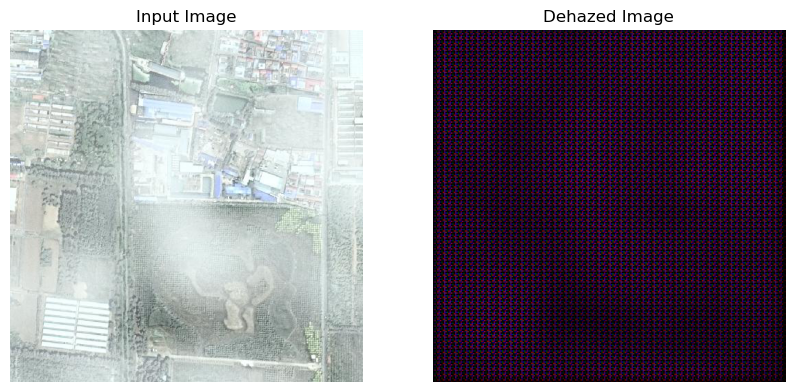

In [5]:
import cv2
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import gc

# Clear any prior sessions to avoid memory overload
tf.keras.backend.clear_session()

# Load the pre-trained model
model = load_model("Nilesh_pix2pix_dehaze.h5")

# Function to preprocess the image (resize, normalize, etc.)
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize to [0, 1] range
    return np.expand_dims(img, axis=0)  # Add batch dimension

# Function to postprocess the model output (convert to proper image format)
def postprocess_output(output):
    output = output.squeeze()  # Remove batch dimension
    output = np.clip(output, 0, 1)  # Ensure pixel values are in [0, 1]
    output = (output * 255).astype(np.uint8)  # Convert back to [0, 255] range
    return output

# Function to clear memory and free up GPU resources
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()

# Main image dehazing function
def dehaze_image(input_image_path, output_image_path):
    try:
        # Preprocess the input image
        input_image = preprocess_image(input_image_path)
        print(f"Input image shape: {input_image.shape}")

        # Predict the dehazed image using the model
        model_output = model.predict(input_image)
        print(f"Model output shape: {model_output.shape}")

        # Postprocess the output to convert it to a viewable image
        dehazed_image = postprocess_output(model_output)
        
        # Save the dehazed image
        cv2.imwrite(output_image_path, cv2.cvtColor(dehazed_image, cv2.COLOR_RGB2BGR))
        print(f"Dehazed image saved successfully at {output_image_path}")

        # Display the input and dehazed images
        input_img_display = cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(input_img_display)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(dehazed_image)
        plt.title("Dehazed Image")
        plt.axis('off')
        
        plt.show()

        # Clear memory after operation
        clear_memory()

    except Exception as e:
        print(f"An error occurred: {e}")

# Specify paths for the input and output images
input_image_path = r'C:\Users\Nilesh\multispectral_image_dehazing\Data_for_dehazing model\paired_data\test\Input\027.png'
output_image_path = "dehazed_image.jpg"

# Run the dehazing function
dehaze_image(input_image_path, output_image_path)


In [64]:
import tensorflow as tf
from tqdm import tqdm
import os

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Define checkpoint directory
CHECKPOINT_DIR = "./pix2pix_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define checkpoint manager
checkpoint = tf.train.Checkpoint(
    generator=generator, 
    discriminator=discriminator, 
    generator_optimizer=generator_optimizer, 
    discriminator_optimizer=discriminator_optimizer,
    epoch=tf.Variable(0)  # Track the current epoch
)
manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

# Restore from checkpoint if available
if manager.latest_checkpoint:
    checkpoint.restore(manager.latest_checkpoint)
    print(f"✅ Restored from checkpoint: {manager.latest_checkpoint}")
    start_epoch = checkpoint.epoch.numpy()  # Start from the saved epoch
else:
    print("⚠️ No checkpoint found, starting from scratch!")
    start_epoch = 0  # Start from epoch 0 if no checkpoint exists

# Define loss functions
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    # Adversarial loss
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    # L1 loss for pixel-wise similarity
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_loss = gan_loss + (100 * l1_loss)  # L1 loss weighted by 100
    return total_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Use @tf.function for speed optimization
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape(persistent=True) as tape:
        generated_image = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target_image], training=True)
        disc_generated_output = discriminator([input_image, generated_image], training=True)

        gen_loss = generator_loss(disc_generated_output, generated_image, target_image)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute gradients
    gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradient clipping to prevent instability
    gen_gradients = [tf.clip_by_norm(g, 5.0) for g in gen_gradients if g is not None]
    disc_gradients = [tf.clip_by_norm(g, 5.0) for g in disc_gradients if g is not None]

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return {"gen_loss": gen_loss, "disc_loss": disc_loss}

# Set number of epochs
EPOCHS = 4
BATCH_SIZE = 16  # Adjust as per available memory

# Prepare dataset with batching for efficiency
train_dataset = tf.data.Dataset.zip((Hazed_train_ds, Dehazed_train_ds))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Training loop
try:
    for epoch in tqdm(range(start_epoch, EPOCHS), desc="Epochs", unit="epoch"):
        epoch_losses = {"gen_loss": 0.0, "disc_loss": 0.0}
        num_batches = 0

        # Inner progress bar for batches in the current epoch
        for hazy_img, dehazy_img in tqdm(train_dataset, desc=f"Epoch {epoch+1}", leave=False):
            losses = train_step(hazy_img, dehazy_img)

            # Accumulate losses
            for key in epoch_losses:
                epoch_losses[key] += losses[key]
            num_batches += 1

        # Compute average losses for the epoch
        avg_losses = {key: float(val) / num_batches for key, val in epoch_losses.items()}
        tqdm.write(f"📊 Epoch {epoch+1}/{EPOCHS} | Gen Loss: {avg_losses['gen_loss']:.4f} | Disc Loss: {avg_losses['disc_loss']:.4f}")
        
        # Save checkpoint after each epoch
        checkpoint.epoch.assign(epoch + 1)
        manager.save()
        print(f"💾 Checkpoint saved at epoch {epoch+1}")

    # Save the trained generator model
    generator.save("Nilesh_pix2pix_dehaze.h5")
    print("✅ Model saved successfully.")

except Exception as e:
    print(f"❌ Error during training: {e}")


NameError: name 'generator_optimizer' is not defined

In [1]:
import tensorflow as tf

# Load the model
model_path = "Nilesh_pix2pix_dehaze.keras"  # Adjust path if needed
model = tf.keras.models.load_model(model_path)

# Print model summary
model.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,507 (5.03 MB)

 Trainable params: 1,317,507 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Activation

def build_sequential_generator():
    model = Sequential()

    # Encoder (Downsampling)
    model.add(Conv2D(64, (4, 4), strides=2, padding="same", input_shape=(256, 256, 3)))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(128, (4, 4), strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(256, (4, 4), strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # Decoder (Upsampling)
    model.add(Conv2DTranspose(128, (4, 4), strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(64, (4, 4), strides=2, padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(3, (4, 4), strides=2, padding="same"))
    model.add(Activation("tanh"))  # Output scaled between -1 and 1

    return model

generator = build_sequential_generator()
generator.summary()


C:\Users\Nilesh\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Nilesh\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 128, 128, 64)   │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 256, 256, 3)    │         3,075 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,319,811 (5.03 MB)

 Trainable params: 1,318,659 (5.03 MB)

 Non-trainable params: 1,152 (4.50 KB)